# Clustering

In [571]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import collections
from scipy import stats

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA

# Clustering
from sklearn import cluster, preprocessing, metrics, mixture
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics.cluster import adjusted_rand_score

# Visualization
from sklearn import manifold

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Defining a few functions which will help us with clustering

In [628]:
# getting most frequent product label for each customer
def get_first_element(s):
    """In the case s is a pd.Series containing tuples of arrays, returns the first element of the first
    array."""
    
    return s.map(lambda x: x[0][0])


def make_score(clusters):
    
    cols = clusters.columns.drop("n_individuals")
    n_feats = len(cols)
    n_clust = clusters.shape[0]
    scores = np.empty((n_feats, n_clust))
    
    for i, col in enumerate(cols):
    
        # creation of the bins
        min_val = clusters[col].min()
        max_val = clusters[col].max()
        steps = (max_val - min_val)/5
        bins = np.arange(min_val, max_val, steps) 
        
        # digitize
        scores[i, :] = np.digitize(clusters[col], bins)

    scores = pd.concat([pd.DataFrame(data=scores.T, columns=cols), clusters.n_individuals], axis=1)
    return scores
    

# plot personae as bar plot
def plot_personae(clusters):
    n_clust = clusters.shape[0]
    c = clusters[clusters.columns[:-1]]
    
    n_rows = n_clust//2 + n_clust%2
    n_cols = 2
    fig = plt.figure(figsize=(10, 5*n_rows))

    for ind in range(n_clust):
        ax = fig.add_subplot(n_rows, n_cols, ind +1)
        sns.barplot(y=c.columns, x=c.iloc[ind], ax=ax)
        ax.set_title("Personae n°{} ({} customers)".format(ind, round(clusters.iloc[ind]["n_individuals"])))
        ax.set_xlim([c.min().min(), c.max().max()])

    plt.tight_layout()
    plt.show()
    

def eval_stability(X, n_clust, init='random', n_run=10):
    
    aris = []
    initial_centroids = X_std.sample(n_clust)
    clusters = cluster.KMeans(n_clusters=n_clust, init=initial_centroids).fit(X_std)
    labels_orig = clusters.labels_
    print("Clustering stability evaluation")
    print("Run\tAdjusted Rand Index")
    
    for i in range(n_run):
        
        if init=='random':
            initial_centroids = X_std.sample(n_clust)
        elif init=='chained':
            initial_centroids = clusters.cluster_centers_
        
        clusters = cluster.KMeans(n_clusters=n_clust, init=initial_centroids).fit(X_std)
        labels_new = clusters.labels_
        ari = adjusted_rand_score(labels_orig, labels_new)
        aris.append(ari)
        print("Run n°{:.0f}\t{:.3f}".format(i, ari))
    
    print("Mean ARI: {:.3f}, standard deviation: {:.3f}".format(np.mean(aris), np.std(aris)))


def get_time_slices(data, freq="months", periods=6, first_slice=False, first_freq="years", first_period=1):
    """Slices the data in equally-spaced or non-equally spaced
    time periods in order to test configurations where, for instance, the first 
    time period is equal to a year, while the subsequent periods are equal to 6 months.
    """
    
    X = data.copy()
    df_slices = []
    duration = {freq:periods}
    first_slice_duration = {first_freq:first_period}
    start_date = X.order_purchase_timestamp.min()
    end_date = start_date
    
    if first_slice:
        end_date = start_date + pd.DateOffset(**first_slice_duration)
        df_first = X.query('order_purchase_timestamp<@end_date')
        #X = X.query('order_purchase_timestamp>@end_date')
        df_slices.append(df_first)
        
        # update start_date
        start_date = end_date

    while end_date < X.order_purchase_timestamp.max():
        end_date = start_date + pd.DateOffset(**duration)
        df_slice = X.query('order_purchase_timestamp<@end_date')
        start_date = end_date
        #X = X.query('order_purchase_timestamp>@end_date')
        
        df_slices.append(df_slice)
    
    print("Creation of the following slices:")
    print("DataFrame #\tStart time\t\tEnd time")
    print("-"*40)
    for i in range(len(df_slices)):    
        start = df_slices[i].order_purchase_timestamp.min()
        end = df_slices[i].order_purchase_timestamp.max()
        print(f"DataFrame #{i}\t{start}\t{end}")
        
    return df_slices


def grouped_value_counts(data, grouping_var, target_var):
    """A script that performs groupby on the grouping_var variable, and returns value_counts
    on the grouped object"""
    
    new_var = (data.groupby(grouping_var)[target_var]
                      .pipe(lambda grp: grp.value_counts())
                      .unstack()
                      .fillna(0)
              )
    
    return new_var


def pca(data, pcacolumns, n_components=5):
    """ PCA on the product categories variables """
    
    ## préparation des données pour l'ACP ##
    X = data[pcacolumns].copy()
    names = X.index 
    features = X.columns

    # standardization
    std_scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scaler.transform(X)

    ## Compute principal components ##
    pca = PCA(n_components=n_components)
    X_pca = pd.DataFrame(data=pca.fit_transform(X_scaled), 
                         columns=["accessories+_care_renovation-",
                                  "health+_toys-",
                                  "home+_toys-",
                                  "fashion_clothing",
                                  "food_beverages"
                                 ],
                         index=names
                        )

    data = pd.concat((data.drop(columns=pcacolumns), X_pca), axis=1)
    
    return data


def data_preprocessing(data, rm_outliers=False, perc=0.99):
    """Realizes all the data preprocessing operations detailed in the exploratory notebook."""
    
    # create variables to merge with data on the customer_unique_id key
    product_categories = grouped_value_counts(data, "customer_unique_id", "product_category")
    review_comment_message = grouped_value_counts(data, "customer_unique_id", "review_comment_message")
    payment_types = grouped_value_counts(data, "customer_unique_id", "payment_type")
    state_labels = grouped_value_counts(data, "customer_unique_id","state_label")
    
    # groupby operation to create a new dataframe along customer_unique_id index from original variables
    data = (data.groupby("customer_unique_id")
            .agg({"order_id":"count",
                  "purchase_recency":"max",
                  "monetary_value":"mean",
                  "purchase_to_delivery_time":"mean",
                  "review_score":"mean",
                  "elapsed_time":"mean",
                  "payment_installments":"mean",
                  "payment_sequential":"mean",
                  "payment_sequential":"mean",
                  "value_for_type":"mean"
                 })
            .rename(columns={"order_id":"frequency",
                             "purchase_to_delivery":"mean_purchase_to_delivery",
                             "review_score":"mean_review_score",
                             "elapsed_time":"mean_comment_elapsed_time",
                             "payment_installments":"mean_nb_installments",
                             "payment_sequential":"mean_nb_payment_types",
                             "value_for_type":"mean_value_for_type"
                            }
                   )
           )
    
    for var in [product_categories, review_comment_message]: 
        data = pd.merge(data, var, on="customer_unique_id")
        
    # remove outliers
    if rm_outliers:
        outliers_indices = pd.Index([])

        for col in data.columns.drop(cat_cols):
            out = data[col].quantile(perc)
            outliers_indices = outliers_indices.append(data[data[col]>out].index)

        data = data.drop(index=outliers_indices)
        
    # PCA on the product variables
    pca_columns = ["accessories",
                   "fashion_clothing",
                   "food_beverages",
                   "health_beauty_baby",
                   "home_garden_tools",
                   "toys_hobby"]
    
    data = pca(data, pca_columns, n_components=5)
    
    # Remove unwanted columns
    cols = ["mean_nb_payment_types", 'no_comment', 'mean_value_for_type']

    for col in cols:
        try:
            data.drop(columns=col, inplace=True)
        except:
            pass
    
    # sort index
    data.sort_index(inplace=True)
    
    return data

# Segmentation with Kmeans

In [428]:
data = pd.read_csv("./data/data.csv")
data.head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_comment_elapsed_time,mean_nb_installments,comment,accessories+_care_renovation-,health+_toys-,home+_toys-,fashion_clothing,food_beverages
0000366f3b9a7992bf8c76cfdf3221e2,1,111,141.90,6.0,5.0,4.0,8.0,1.0,0.946641,0.019995,-0.031377,-0.028715,-0.008333
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114,27.19,3.0,4.0,0.0,1.0,0.0,-1.413189,1.923199,-0.409611,-0.247437,-0.108109
0000f46a3911fa3c0805444483337064,1,536,86.22,25.0,3.0,1.0,8.0,0.0,0.946641,0.019995,-0.031377,-0.028715,-0.008333
0000f6ccb0745a6a4b88665a16c9f078,1,320,43.62,20.0,4.0,1.0,4.0,1.0,0.946641,0.019995,-0.031377,-0.028715,-0.008333
0004aac84e0df4da2b147fca70cf8255,1,287,196.89,13.0,5.0,4.0,6.0,0.0,0.946641,0.019995,-0.031377,-0.028715,-0.008333


<AxesSubplot:>

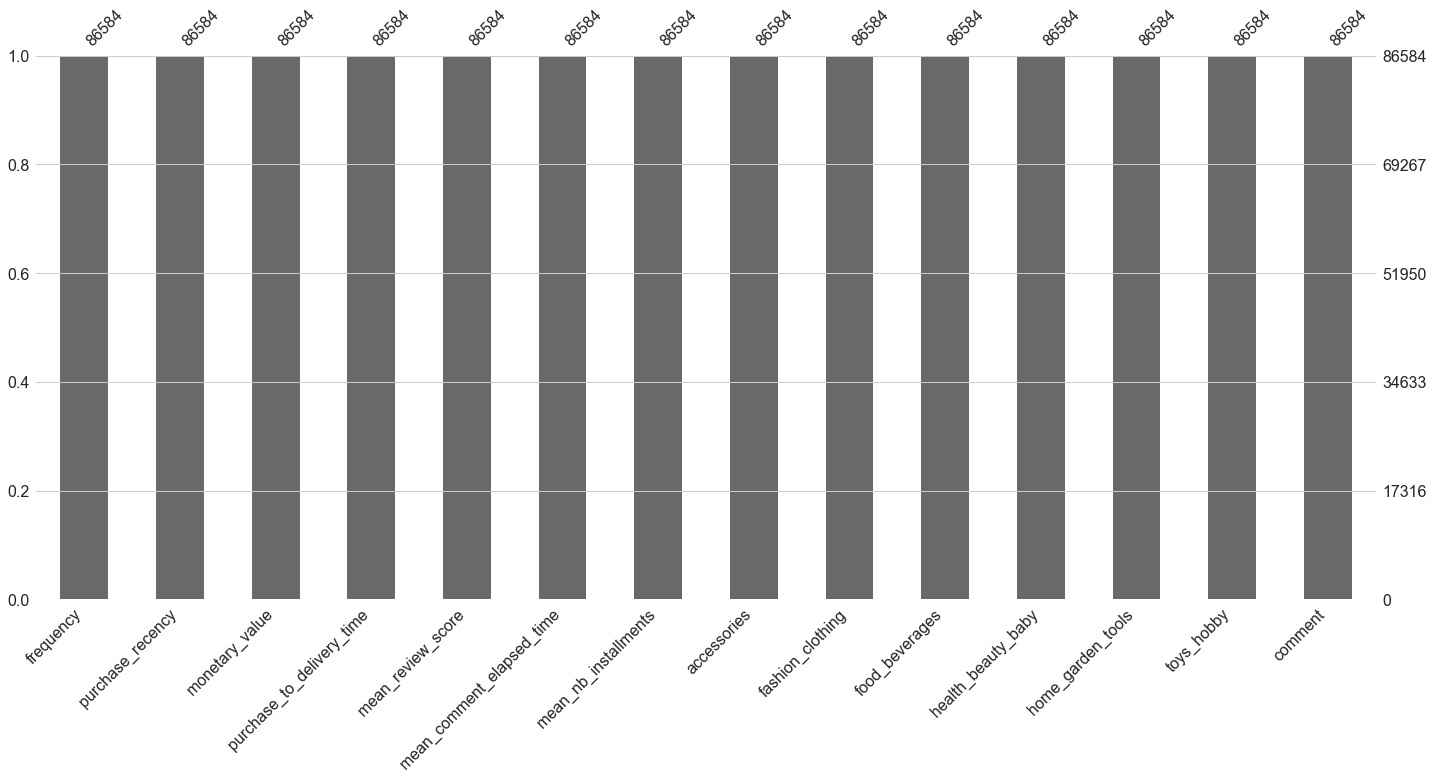

In [399]:
msno.bar(data)

In [401]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86584 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   frequency                  86584 non-null  int64  
 1   purchase_recency           86584 non-null  int64  
 2   monetary_value             86584 non-null  float64
 3   purchase_to_delivery_time  86584 non-null  float64
 4   mean_review_score          86584 non-null  float64
 5   mean_comment_elapsed_time  86584 non-null  float64
 6   mean_nb_installments       86584 non-null  float64
 7   accessories                86584 non-null  float64
 8   fashion_clothing           86584 non-null  float64
 9   food_beverages             86584 non-null  float64
 10  health_beauty_baby         86584 non-null  float64
 11  home_garden_tools          86584 non-null  float64
 12  toys_hobby                 86584 non-null  float6

In [543]:
X = data.copy()
cat_cols = X.columns[7:]

# Standard scaling of numerical features
numeric_transformer = StandardScaler()  
preproc = ColumnTransformer(transformers=[('num', StandardScaler(), X.columns.drop(cat_cols))],
                            remainder='passthrough'
                           )

X_std = pd.DataFrame(data=preproc.fit_transform(X), columns=X.columns, index= X.index)
X_std.head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_comment_elapsed_time,mean_nb_installments,comment,accessories+_care_renovation-,health+_toys-,home+_toys-,fashion_clothing,food_beverages
0000366f3b9a7992bf8c76cfdf3221e2,-0.243117,-0.810882,0.032757,-0.719130,0.656935,0.862135,2.016839,1.0,0.946641,0.019995,-0.031377,-0.028715,-0.008333
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.243117,-0.790557,-0.831513,-1.107801,-0.135726,-0.813124,-0.715975,0.0,-1.413189,1.923199,-0.409611,-0.247437,-0.108109
0000f46a3911fa3c0805444483337064,-0.243117,2.068454,-0.386758,1.742450,-0.928388,-0.394309,2.016839,0.0,0.946641,0.019995,-0.031377,-0.028715,-0.008333
0000f6ccb0745a6a4b88665a16c9f078,-0.243117,0.605074,-0.707723,1.094666,-0.135726,-0.394309,0.455231,1.0,0.946641,0.019995,-0.031377,-0.028715,-0.008333
0004aac84e0df4da2b147fca70cf8255,-0.243117,0.381502,0.447073,0.187768,0.656935,0.862135,1.236035,0.0,0.946641,0.019995,-0.031377,-0.028715,-0.008333


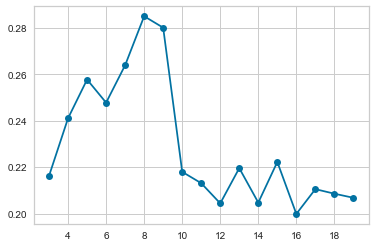

In [429]:
silhouettes = []

for num_clusters in range(3, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(3, 20), silhouettes, marker='o')

2. Elbow method

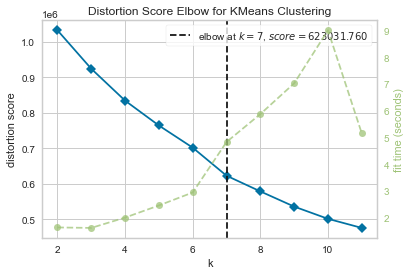

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [430]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

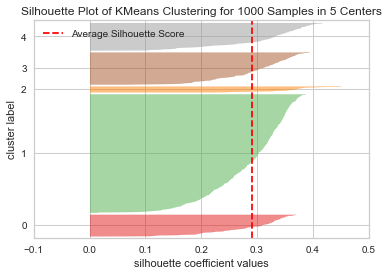

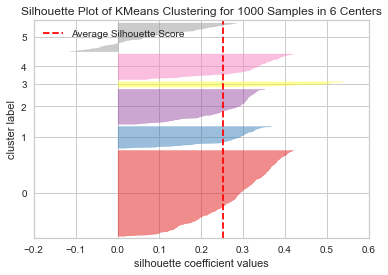

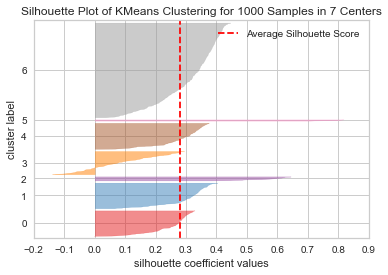

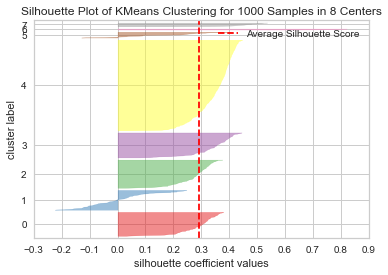

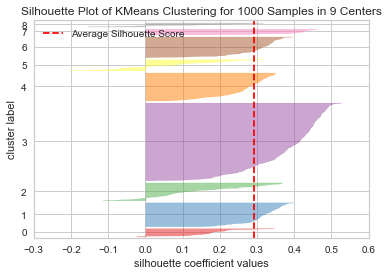

In [431]:
for n_clust in range(5, 10):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std.sample(1000))    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

It seems that 6 clusters appear to be the best choice judging by the silhoutte scores and the results from the SilhouetteVisualizer. Let us look at the centroids in order to get a better sense of the quality of the clustering

### Characterization of the clusters
In order to characterize the clusters, we have a look at the centroids. Interpreting the values (coordinates) of the centroids will help us define the personae corresponding to each cluster

In [545]:
# 6 clusters

clusters = cluster.KMeans(n_clusters=6).fit(X_std)
centers = pd.DataFrame(clusters.cluster_centers_, columns=X.columns)
n_individuals = pd.Series(np.array(sorted(collections.Counter(clusters.labels_).items()))[:, 1], name="n_individuals")
clusters_data = pd.concat((centers, n_individuals), axis=1)

clus_mean = pd.DataFrame(data=np.array(clusters_data.mean()).reshape(1, 14),
             columns=clusters_data.mean().index,
             index=["mean"])

clus_std = pd.DataFrame(data=np.array(clusters_data.std()).reshape(1, 14),
             columns=clusters_data.mean().index,
             index=["std"])

pd.concat([clusters_data, clus_mean, clus_std])

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_comment_elapsed_time,mean_nb_installments,comment,accessories+_care_renovation-,health+_toys-,home+_toys-,fashion_clothing,food_beverages,n_individuals
0,0.176232,0.158451,1.178476,0.156736,-0.079841,-0.018632,1.456536,0.506345,0.551212,-0.003536,-0.018775,1.185595,-0.099966,10132.000000
1,-0.043793,-0.018824,-0.231554,0.014744,-0.020347,0.002795,-0.325530,0.430531,1.032961,0.022673,-0.034453,-0.033017,-0.009846,41078.000000
2,0.045837,-0.090046,-0.116029,-0.064502,0.016815,0.004163,0.011987,0.447663,-1.233728,-0.738349,2.439790,-0.356596,-0.168341,10183.000000
3,0.164307,-0.271947,-0.444280,-0.246949,0.140529,-0.075067,-0.410443,0.385093,-1.098794,-0.167933,0.184571,0.611738,12.861778,483.000000
4,-0.036466,-0.089389,-0.022752,-0.067371,0.055247,-0.004141,0.030359,0.391892,-1.442313,2.016735,-0.432812,-0.260826,-0.114826,13022.000000
5,-0.005592,0.117597,-0.067050,-0.046606,0.058862,0.010480,-0.151026,0.392197,-1.378859,-1.673519,-1.513880,-0.339103,-0.135363,11686.000000
mean,0.050088,-0.032360,0.049469,-0.042325,0.028544,-0.013400,0.101981,0.425620,-0.594920,-0.090655,0.104073,0.134632,2.055573,14430.666667
std,0.098369,0.156883,0.573341,0.131065,0.075430,0.031802,0.686645,0.046741,1.091624,1.215933,1.296330,0.629663,5.294204,13788.810850


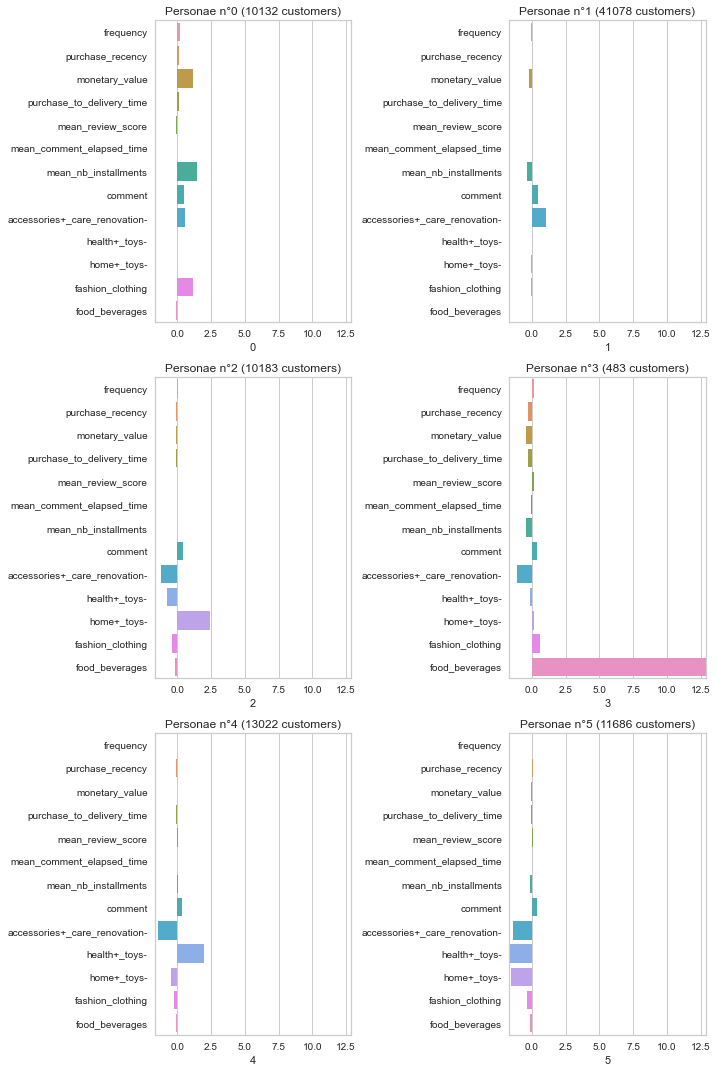

In [556]:
#scores = make_score(clusters_data)
plot_personae(clusters_data)

There is one small cluster which is mainly characterized by oustanding values for the frequency and food_beverages variables. What if we drop this category? We'll also drop "mean_comment_elapsed_time" since it is not very informative.

In [434]:
pd.Series(data.drop(columns=["food_beverages", "mean_comment_elapsed_time"]).columns)

0                         frequency
1                  purchase_recency
2                    monetary_value
3         purchase_to_delivery_time
4                 mean_review_score
5              mean_nb_installments
6                           comment
7     accessories+_care_renovation-
8                     health+_toys-
9                       home+_toys-
10                 fashion_clothing
dtype: object

In [531]:
X = data.drop(columns=["food_beverages", "mean_comment_elapsed_time"]).copy()
cat_cols = X.columns[6:]

# Standard scaling of numerical features
numeric_transformer = StandardScaler()  
preproc = ColumnTransformer(transformers=[('num', StandardScaler(), X.columns.drop(cat_cols))],
                            remainder='passthrough'
                           )

X_std = pd.DataFrame(data=preproc.fit_transform(X), columns=X.columns)
X_std.head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_nb_installments,comment,accessories+_care_renovation-,health+_toys-,home+_toys-,fashion_clothing
0,-0.243117,-0.810882,0.032757,-0.719130,0.656935,2.016839,1.0,0.946641,0.019995,-0.031377,-0.028715
1,-0.243117,-0.790557,-0.831513,-1.107801,-0.135726,-0.715975,0.0,-1.413189,1.923199,-0.409611,-0.247437
2,-0.243117,2.068454,-0.386758,1.742450,-0.928388,2.016839,0.0,0.946641,0.019995,-0.031377,-0.028715
3,-0.243117,0.605074,-0.707723,1.094666,-0.135726,0.455231,1.0,0.946641,0.019995,-0.031377,-0.028715
4,-0.243117,0.381502,0.447073,0.187768,0.656935,1.236035,0.0,0.946641,0.019995,-0.031377,-0.028715


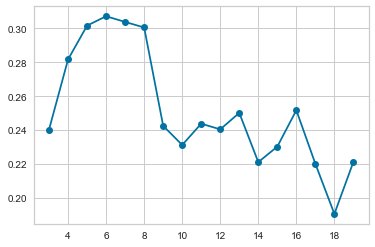

In [436]:
silhouettes = []

silhouettes = []

for num_clusters in range(3, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(3, 20), silhouettes, marker='o')

2. Elbow method

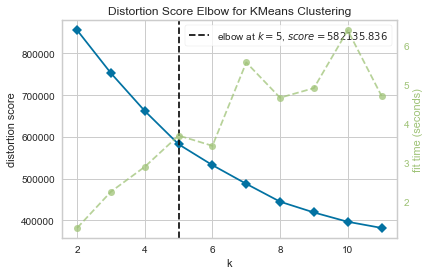

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [437]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

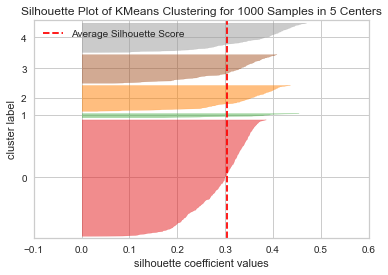

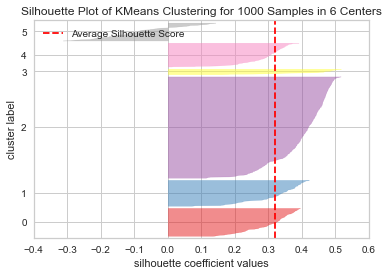

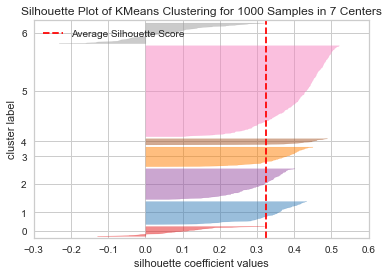

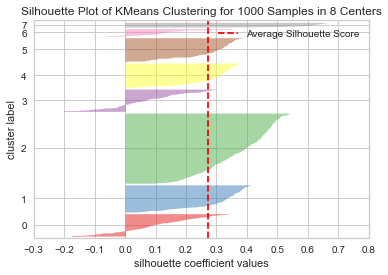

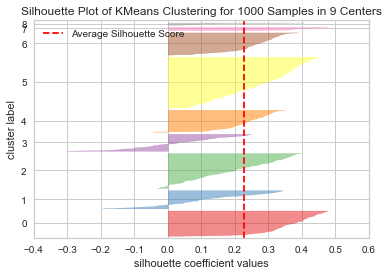

In [438]:
for n_clust in range(5, 10):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std.sample(1000))    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

### Characterization of the clusters
In order to characterize the clusters, we have a look at the centroids. Interpreting the values (coordinates) of the centroids will help us define the personae corresponding to each cluster

In [440]:
# 5 clusters

clusters = cluster.KMeans(n_clusters=5).fit(X_std)
centers = pd.DataFrame(data=clusters.cluster_centers_, columns=X_std.columns)

n_individuals = pd.Series(np.array(sorted(collections.Counter(clusters.labels_).items()))[:, 1],
                          name="n_individuals")
clusters_data = pd.concat((centers, n_individuals), axis=1)

clus_mean = pd.DataFrame(data=np.array(clusters_data.mean()).reshape(1, 12),
             columns=clusters_data.mean().index,
             index=["mean"])

clus_std = pd.DataFrame(data=np.array(clusters_data.std()).reshape(1, 12),
             columns=clusters_data.std().index,
             index=["std"])

pd.concat([clusters_data, clus_mean, clus_std])

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_nb_installments,comment,accessories+_care_renovation-,health+_toys-,home+_toys-,fashion_clothing,n_individuals
0,0.383431,0.147615,0.810082,0.702011,-0.781640,0.940727,0.633840,1.124061,0.030738,-0.044326,0.033008,14371.000000
1,-0.036866,-0.087687,0.023419,-0.076748,0.067954,0.049910,0.389675,-1.445228,2.015689,-0.432523,-0.253435,13150.000000
2,0.051880,-0.090101,-0.082960,-0.068634,0.026708,0.025822,0.446024,-1.237661,-0.737707,2.435834,-0.348114,10273.000000
3,-0.004695,0.118506,-0.037084,-0.057190,0.069465,-0.131345,0.390451,-1.381597,-1.673756,-1.513228,-0.331205,11768.000000
4,-0.149212,-0.039023,-0.289130,-0.208973,0.250869,-0.349673,0.373536,0.859632,0.008843,-0.023902,0.279411,37022.000000
mean,0.048908,0.009862,0.084866,0.058093,-0.073329,0.107088,0.446705,-0.416159,-0.071239,0.084371,-0.124067,17316.800000
std,0.200871,0.114758,0.422085,0.365201,0.405329,0.492521,0.108156,1.290914,1.358705,1.447167,0.272629,11121.366449


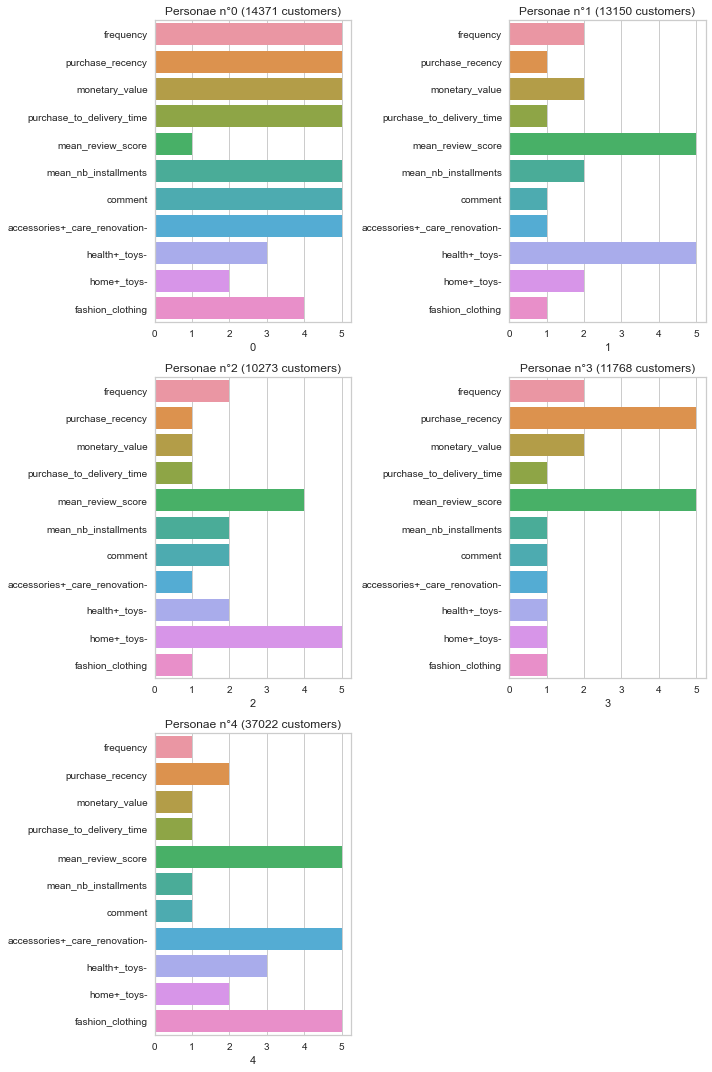

In [441]:
plot_personae(scores)

## Stability

In [541]:
eval_stability(X_std, 5)

Clustering stability evaluation
Run	Adjusted Rand Index
Run n°0	0.483
Run n°1	0.918
Run n°2	0.529
Run n°3	0.514
Run n°4	0.347
Run n°5	0.448
Run n°6	0.989
Run n°7	0.573
Run n°8	0.737
Run n°9	0.526
Mean ARI: 0.607, standard deviation: 0.197


**Without the _comment_ variable**

In [451]:
pd.Series(data.drop(columns=["food_beverages", "mean_comment_elapsed_time", "comment"]).columns)

0                        frequency
1                 purchase_recency
2                   monetary_value
3        purchase_to_delivery_time
4                mean_review_score
5             mean_nb_installments
6    accessories+_care_renovation-
7                    health+_toys-
8                      home+_toys-
9                 fashion_clothing
dtype: object

In [557]:
X = data.drop(columns=["food_beverages", "mean_comment_elapsed_time", "comment"]).copy()
cat_cols = X.columns[6:]

# Standard scaling of numerical features
numeric_transformer = StandardScaler()  
preproc = ColumnTransformer(transformers=[('num', StandardScaler(), X.columns.drop(cat_cols))],
                            remainder='passthrough'
                           )

X_std = pd.DataFrame(data=preproc.fit_transform(X), columns=X.columns, index=X.index)
X_std.head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_nb_installments,accessories+_care_renovation-,health+_toys-,home+_toys-,fashion_clothing
0000366f3b9a7992bf8c76cfdf3221e2,-0.243117,-0.810882,0.032757,-0.719130,0.656935,2.016839,0.946641,0.019995,-0.031377,-0.028715
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.243117,-0.790557,-0.831513,-1.107801,-0.135726,-0.715975,-1.413189,1.923199,-0.409611,-0.247437
0000f46a3911fa3c0805444483337064,-0.243117,2.068454,-0.386758,1.742450,-0.928388,2.016839,0.946641,0.019995,-0.031377,-0.028715
0000f6ccb0745a6a4b88665a16c9f078,-0.243117,0.605074,-0.707723,1.094666,-0.135726,0.455231,0.946641,0.019995,-0.031377,-0.028715
0004aac84e0df4da2b147fca70cf8255,-0.243117,0.381502,0.447073,0.187768,0.656935,1.236035,0.946641,0.019995,-0.031377,-0.028715


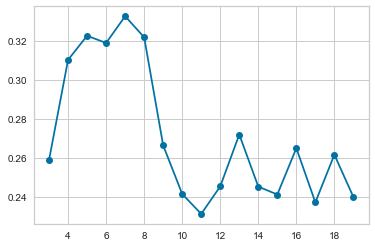

In [453]:
silhouettes = []

silhouettes = []

for num_clusters in range(3, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(3, 20), silhouettes, marker='o')

2. Elbow method

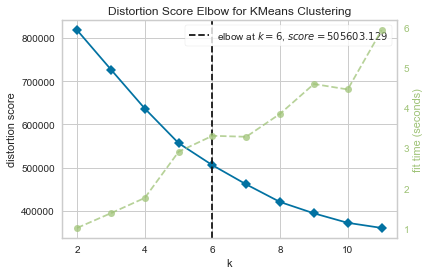

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [454]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

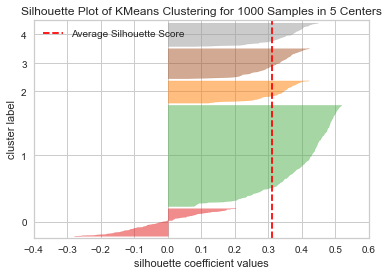

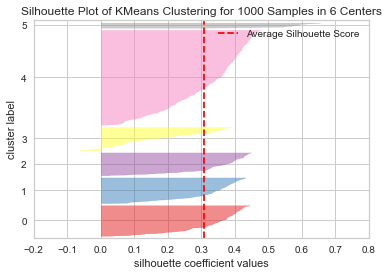

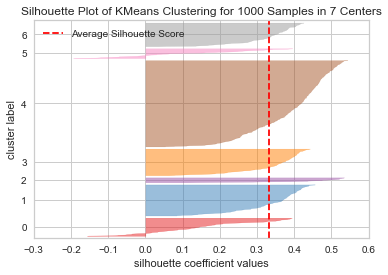

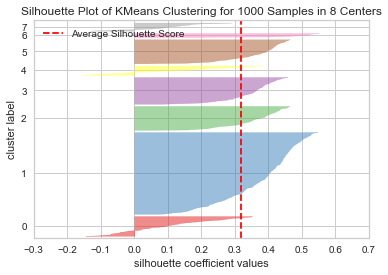

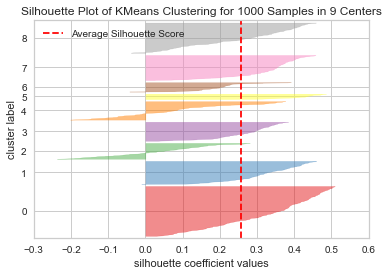

In [455]:
for n_clust in range(5, 10):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std.sample(1000))    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

### Characterization of the clusters
In order to characterize the clusters, we have a look at the centroids. Interpreting the values (coordinates) of the centroids will help us define the personae corresponding to each cluster

In [558]:
# 7 clusters

clusters = cluster.KMeans(n_clusters=7).fit(X_std)
centers = pd.DataFrame(data=clusters.cluster_centers_, columns=X_std.columns)

n_individuals = pd.Series(np.array(sorted(collections.Counter(clusters.labels_).items()))[:, 1],
                          name="n_individuals")
clusters_data = pd.concat((centers, n_individuals), axis=1)

clus_mean = pd.DataFrame(data=np.array(clusters_data.mean()).reshape(1, 11),
             columns=clusters_data.mean().index,
             index=["mean"])

clus_std = pd.DataFrame(data=np.array(clusters_data.std()).reshape(1, 11),
             columns=clusters_data.std().index,
             index=["std"])

pd.concat([clusters_data, clus_mean, clus_std])

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_nb_installments,accessories+_care_renovation-,health+_toys-,home+_toys-,fashion_clothing,n_individuals
0,-0.001320,0.121626,-0.093241,-0.147027,0.149709,-0.166912,-1.382957,-1.676899,-1.517405,-0.344181,11179.000000
1,0.341714,0.112684,1.663465,0.038610,0.119831,1.790219,0.949119,0.056506,-0.056163,-0.067487,8021.000000
2,0.287515,0.244983,-0.275178,-0.075990,0.056400,-0.144967,-0.998360,-0.184931,0.089922,5.972691,2111.000000
3,0.052811,-0.090963,-0.130013,-0.128970,0.070317,0.004234,-1.237347,-0.738532,2.439658,-0.357154,9946.000000
4,-0.030226,0.025915,-0.094432,1.312145,-1.956597,-0.077721,0.724380,0.039861,-0.067428,-0.063949,8892.000000
5,-0.093654,-0.028963,-0.261890,-0.195863,0.352279,-0.340163,0.989212,0.020093,-0.031453,-0.024771,34075.000000
6,-0.032484,-0.090675,-0.054833,-0.178989,0.156442,0.002965,-1.447024,2.021780,-0.433771,-0.263276,12360.000000
mean,0.074908,0.042087,0.107697,0.089131,-0.150231,0.152522,-0.343282,-0.066017,0.060480,0.693125,12369.142857
std,0.170140,0.124576,0.691346,0.544982,0.802471,0.731744,1.162855,1.114592,1.185593,2.332190,10121.419061


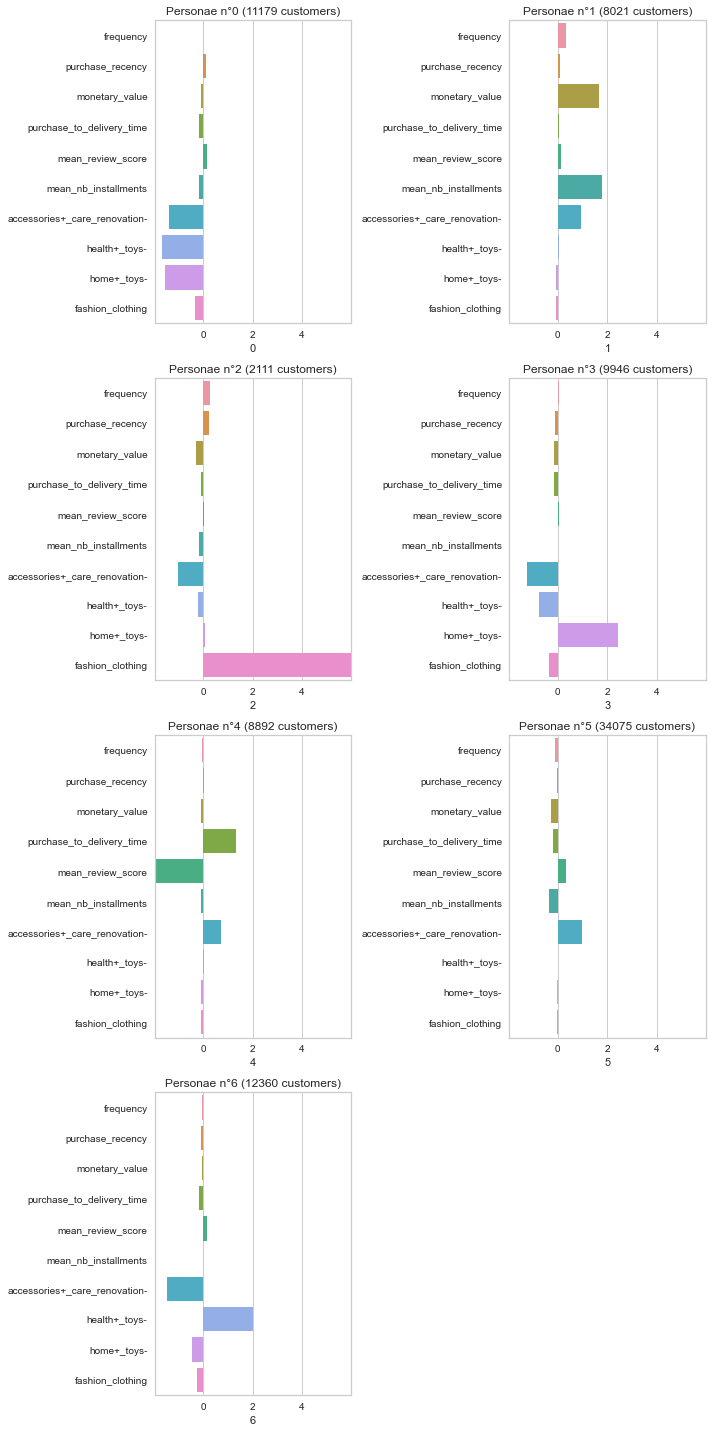

In [559]:
plot_personae(clusters_data)

Persona 0:
- This customer purchased more than once on the website. The review score are good (better than average), the experienced delivery time generally short (thus the satisfaction). This persona buys mostly _toys_hobby_ items, do not purchase for a high value nor in many installments.

Persona 4:
- This persona stands out because of its insatisfaction. This insatisfaction can probably be compared to the generally high _purchase_to_delivery_time_ it has experienced. Besides this, this persona preferentially buys _accessories_ products.

Persona 6:
- The third persona is mostly a buyer of _health_beauty_baby_ products. Besides this, the other stringent features are:
    * a one-time only customer
    * an average-to-low monetary value buyer
    * a happy customer (purchase_to_delivery_time is low)

Persona 3: 
- This persona mostly buys _home_garden_tools_ products. It purchased a little less recently than average, for a less than average monetary value. It is not unsatisfied (average satisfaction) with its experience with olist.

Persona 1:
- The customers represented in this group are "premium" customers:
    * they buy more frequently
    * they buy for a high monetary value (high average order value)
    * they experience low _purchase_to_delivery_time_ and thus
    * they are generally satisfied customers
    * they tend to pay in several installments to accomodate their high value purchases
    * they preferentially buy _accessories_ products, but not only.
    What differentiate them from the persona 4 is the recency, the delivery time and the satisfaction. These customers did generally not use the service recently, which may indicate a change in the way sellers of _accessories_ products deal with their customers.
    
Persona 2:
- These customers represent the smallest group. 
    * They buy frequently
    * for a low monetary value
    * they are generally satisfied, although
    * they did not use the service recently (on average)
    * they do not pay in installments
    * they preferentially buy clothes r other _fashion_clothing_ items 

Persona 5:
- The largest group
    * They buy mostly from _accessories_
    * they purchase for a low monetary value
    * not frequently
    * they're satisfied
    

## Stability

In [560]:
eval_stability(X_std, 6, init='random')

Clustering stability evaluation
Run	Adjusted Rand Index
Run n°0	0.798
Run n°1	0.798
Run n°2	0.563
Run n°3	0.687
Run n°4	0.664
Run n°5	0.796
Run n°6	0.890
Run n°7	0.786
Run n°8	0.720
Run n°9	0.544
Mean ARI: 0.725, standard deviation: 0.105


The average stability of about 0.72 is satisfactory. This tells us that the clustering is somewhat stable, and the clusters we obtained are meaningful.

# segmentation without the products variables

In [414]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86584 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   frequency                  86584 non-null  int64  
 1   purchase_recency           86584 non-null  int64  
 2   monetary_value             86584 non-null  float64
 3   purchase_to_delivery_time  86584 non-null  float64
 4   mean_review_score          86584 non-null  float64
 5   mean_comment_elapsed_time  86584 non-null  float64
 6   mean_nb_installments       86584 non-null  float64
 7   accessories                86584 non-null  float64
 8   fashion_clothing           86584 non-null  float64
 9   food_beverages             86584 non-null  float64
 10  health_beauty_baby         86584 non-null  float64
 11  home_garden_tools          86584 non-null  float64
 12  toys_hobby                 86584 non-null  float6

In [561]:
cat_cols = data.columns[7:]
num_cols = data.columns.drop(cat_cols)

# drop also "mean_comment_elapsed_time"
cols = num_cols.drop("mean_comment_elapsed_time")
X = data[cols].copy()

# Standard scaling of numerical features except mean_value_for_type, which is already standardized
numeric_transformer = StandardScaler()  
preproc = ColumnTransformer(transformers=[('num', StandardScaler(), cols)],
                            remainder='passthrough'
                           )

X_std = pd.DataFrame(data=preproc.fit_transform(X), columns=X.columns, index=X.index)
X_std.head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_nb_installments
0000366f3b9a7992bf8c76cfdf3221e2,-0.243117,-0.810882,0.032757,-0.719130,0.656935,2.016839
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.243117,-0.790557,-0.831513,-1.107801,-0.135726,-0.715975
0000f46a3911fa3c0805444483337064,-0.243117,2.068454,-0.386758,1.742450,-0.928388,2.016839
0000f6ccb0745a6a4b88665a16c9f078,-0.243117,0.605074,-0.707723,1.094666,-0.135726,0.455231
0004aac84e0df4da2b147fca70cf8255,-0.243117,0.381502,0.447073,0.187768,0.656935,1.236035


In [415]:
silhouettes = []

for num_clusters in range(2, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 20), silhouettes, marker='o')

2. Elbow method

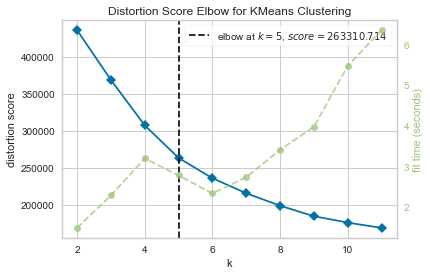

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [417]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

5 clusters seem to be optimal according to the elbow method. What about the shape of these clusters?

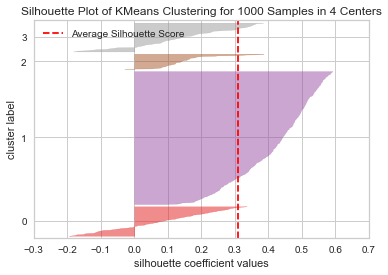

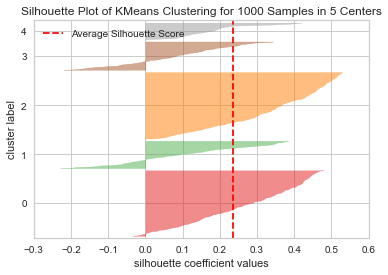

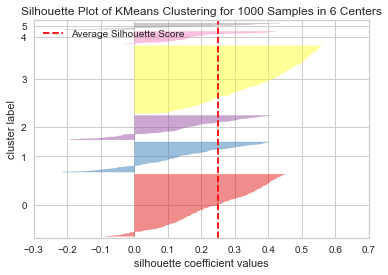

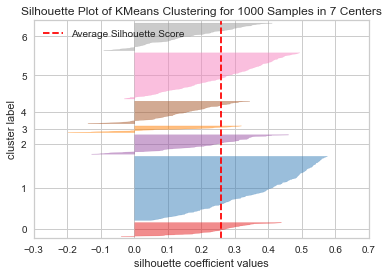

In [418]:
for n_clust in range(4, 8):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std.sample(1000))    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

In [562]:
# 5 clusters

clusters = cluster.KMeans(n_clusters=5).fit(X_std)
centers = pd.DataFrame(data=clusters.cluster_centers_, columns=X_std.columns)

n_individuals = pd.Series(np.array(sorted(collections.Counter(clusters.labels_).items()))[:, 1], name="n_individuals")
clusters_data = pd.concat((centers, n_individuals), axis=1)

clus_mean = pd.DataFrame(data=np.array(clusters_data.mean()).reshape(1, 7),
             columns=clusters_data.mean().index,
             index=["mean"])

clus_std = pd.DataFrame(data=np.array(clusters_data.std()).reshape(1, 7),
             columns=clusters_data.std().index,
             index=["std"])

pd.concat([clusters_data, clus_mean, clus_std])

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_nb_installments,n_individuals
0,-0.243117,0.983665,-0.272110,-0.052416,0.347967,-0.288833,25710.00000
1,-0.243117,-0.782154,-0.267917,-0.369704,0.375822,-0.364078,32552.00000
2,-0.229030,0.044411,1.377834,0.051752,0.198738,1.861904,10928.00000
3,3.402708,-0.018098,0.382332,-0.105489,-0.174564,0.041969,5648.00000
4,-0.217866,-0.029515,-0.132395,1.138566,-1.902619,-0.118012,11746.00000
mean,0.493916,0.039662,0.217549,0.132542,-0.230932,0.226590,17316.80000
std,1.626099,0.627429,0.702018,0.583466,0.959897,0.927582,11297.88251


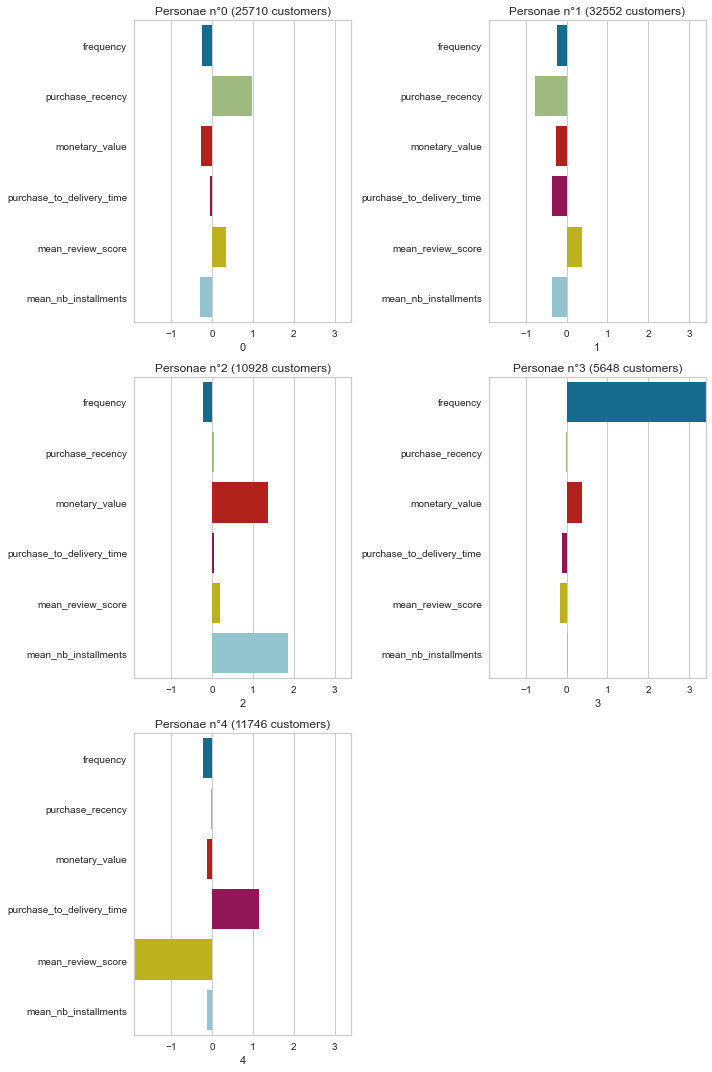

In [563]:
plot_personae(clusters_data)

## Stability

In [564]:
eval_stability(X_std, 5)

Clustering stability evaluation
Run	Adjusted Rand Index
Run n°0	0.676
Run n°1	0.677
Run n°2	0.676
Run n°3	0.302
Run n°4	0.677
Run n°5	0.301
Run n°6	0.677
Run n°7	0.677
Run n°8	0.676
Run n°9	0.676
Mean ARI: 0.601, standard deviation: 0.150


# segmentation rfm
We will try another approach by considering only the recency and monetary value variables. We do not consider the frequency since, as seen in the first notebook, the vast majority of customers have purchased only once over the whole period

In [565]:
rm_cols = ["frequency","purchase_recency", "monetary_value"]
X = data[rm_cols]

# Standard scaling of numerical features except mean_value_for_type, which is already standardized
preproc = ColumnTransformer(transformers=[('num', StandardScaler(), X.columns)],
                            remainder='passthrough'
                           )

X_std = pd.DataFrame(data=preproc.fit_transform(X), columns=X.columns, index=X.index)

X_std.head()

,frequency,purchase_recency,monetary_value
0000366f3b9a7992bf8c76cfdf3221e2,-0.243117,-0.810882,0.032757
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.243117,-0.790557,-0.831513
0000f46a3911fa3c0805444483337064,-0.243117,2.068454,-0.386758
0000f6ccb0745a6a4b88665a16c9f078,-0.243117,0.605074,-0.707723
0004aac84e0df4da2b147fca70cf8255,-0.243117,0.381502,0.447073


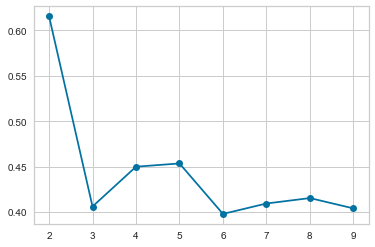

In [469]:
silhouettes = []

for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

2. Elbow method

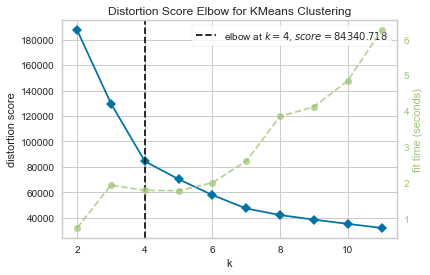

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [470]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

4 to 5 clusters seem to be optimal according to the silhouette score and elbow method. What about the shape of these clusters?

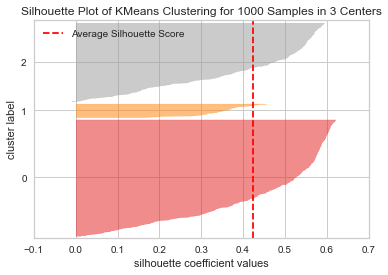

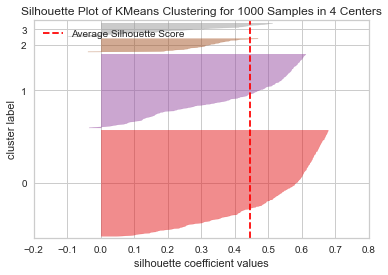

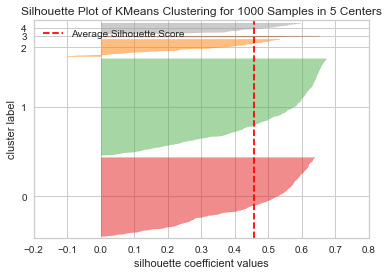

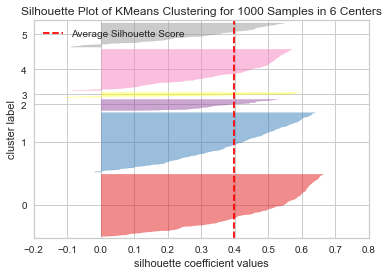

In [471]:
for n_clust in range(3, 7):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std.sample(1000))    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

### Characterization of the clusters
In order to characterize the clusters, we have a look at the centroids. Interpreting the values (coordinates) of the centroids will help us define the personae corresponding to each cluster

In [566]:
# 4 clusters

clusters = cluster.KMeans(n_clusters=4).fit(X_std)
centers = pd.DataFrame(data=clusters.cluster_centers_, columns=X_std.columns)

n_individuals = pd.Series(np.array(sorted(collections.Counter(clusters.labels_).items()))[:, 1], name="n_individuals")
clusters_data = pd.concat((centers, n_individuals), axis=1)

clus_mean = pd.DataFrame(data=np.array(clusters_data.mean()).reshape(1, 4),
             columns=clusters_data.mean().index,
             index=["mean"])

clus_std = pd.DataFrame(data=np.array(clusters_data.std()).reshape(1, 4),
             columns=clusters_data.std().index,
             index=["std"])

pd.concat([clusters_data, clus_mean, clus_std])

,frequency,purchase_recency,monetary_value,n_individuals
0,-0.243117,0.989704,-0.222237,32320.000000
1,-0.178488,-0.049652,2.997318,5081.000000
2,3.398361,-0.018799,0.331090,5690.000000
3,-0.243117,-0.727271,-0.230179,43493.000000
mean,0.683410,0.048496,0.718998,21646.000000
std,1.810224,0.707542,1.541436,19323.723295


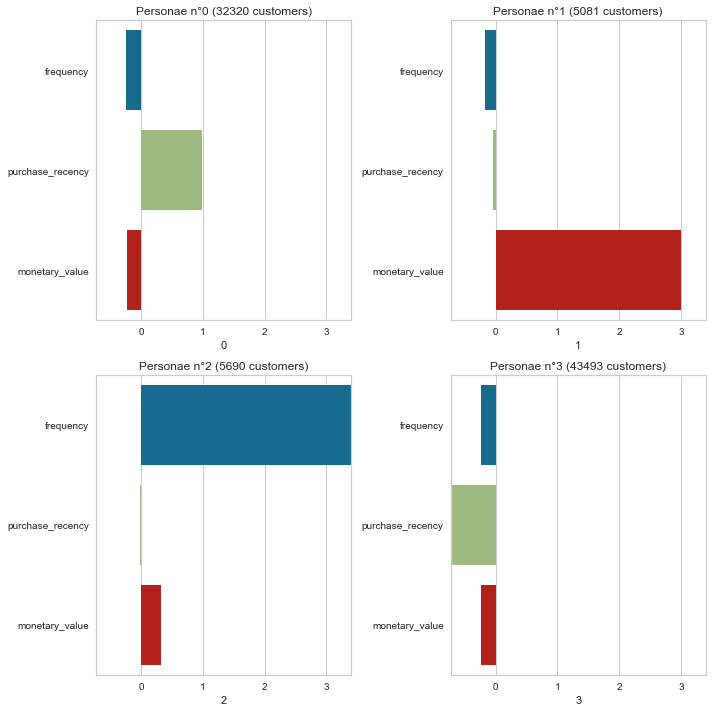

In [567]:
plot_personae(clusters_data)

Personae:

- Persona 3 represents customers who purchase frequently. They tend to purchase for higher monetary values than average.

The other personae represent customers who do not purchase frequently. They can be categorized as follows:
- Personae 0 and 2  are low monetary value customers. 0 represents customers who made their last purchase a long time ago, while customers represented by persona 2 purchased recently. Therefore they can really be seen as the same segment, unless further analysis shows other differences between the two.
- Persona 1 represents very high monetary value customers, who purchase less frequently than average.

these personae aren't very informative, therefore we decide to add more variables to make the clustering more interesting

## Stability

In [568]:
eval_stability(X_std, 4)

Clustering stability evaluation
Run	Adjusted Rand Index
Run n°0	1.000
Run n°1	1.000
Run n°2	1.000
Run n°3	0.995
Run n°4	1.000
Run n°5	1.000
Run n°6	1.000
Run n°7	1.000
Run n°8	1.000
Run n°9	1.000
Mean ARI: 0.999, standard deviation: 0.001


# Stability of the clusters over time

We need to go back to the creation of the main dataframe, which we split into as many dataframes as the number of periods of time we consider. 

# segmentation rfm + customer satisfaction
We now try to cross the rm data with mean review score and purchase_delivery_time to see if we can cluster the customers depending on their satisfaction, and if this satisfaction is related to delivery time

In [488]:
cols = ["frequency","purchase_recency", "monetary_value", "mean_review_score", "purchase_to_delivery_time"]
X = data[cols]

# Standard scaling of numerical features except mean_value_for_type, which is already standardized
preproc = ColumnTransformer(transformers=[('num', StandardScaler(), X.columns)],
                            remainder='passthrough'
                           )

X_std = pd.DataFrame(data=preproc.fit_transform(X), columns=X.columns, index=X.index)

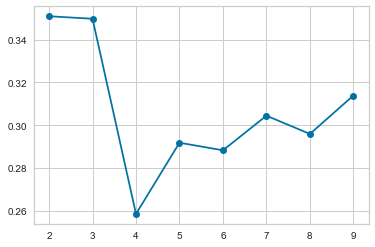

In [443]:
silhouettes = []

for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

2. Elbow method

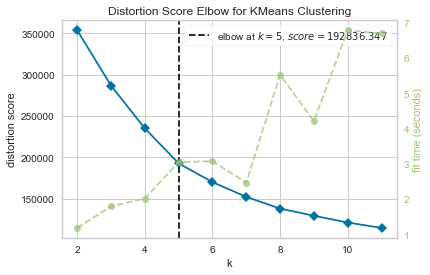

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [489]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

4 to 5 clusters seem to be optimal according to the silhouette score and elbow method. What about the shape of these clusters?

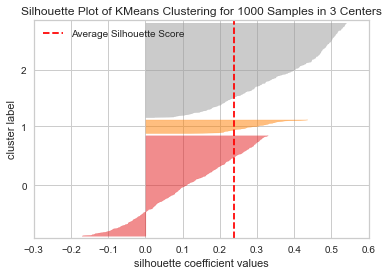

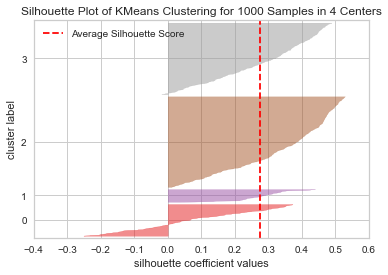

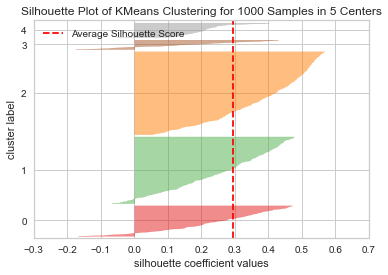

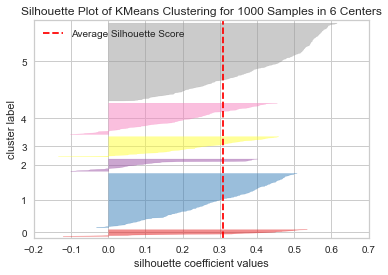

In [490]:
for n_clust in range(3, 7):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std.sample(1000))    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

In [449]:
# 5 clusters

clusters = cluster.KMeans(n_clusters=5).fit(X_std)
centers = pd.DataFrame(data=clusters.cluster_centers_, columns=X_std.columns)

n_individuals = pd.Series(np.array(sorted(collections.Counter(clusters.labels_).items()))[:, 1], name="n_individuals")
clusters_data = pd.concat((centers, n_individuals), axis=1)

clus_mean = pd.DataFrame(data=np.array(clusters_data.mean()).reshape(1, 6),
             columns=clusters_data.mean().index,
             index=["mean"])

clus_std = pd.DataFrame(data=np.array(clusters_data.std()).reshape(1, 6),
             columns=clusters_data.std().index,
             index=["std"])

pd.concat([clusters_data, clus_mean, clus_std])

,frequency,purchase_recency,monetary_value,mean_review_score,purchase_to_delivery_time,n_individuals
0,-0.243117,-0.776580,-0.226149,0.381852,-0.354249,35638.000000
1,-0.221126,-0.023543,-0.132434,-1.850787,1.106527,12529.000000
2,-0.243117,0.988673,-0.209671,0.352462,-0.051323,28590.000000
3,-0.169537,-0.041915,3.261870,0.115464,0.195028,4222.000000
4,3.407673,-0.019948,0.336502,-0.175301,-0.106931,5605.000000
mean,0.506155,0.025337,0.606024,-0.235262,0.157811,17316.800000
std,1.622276,0.628500,1.502444,0.930426,0.565128,14091.792672


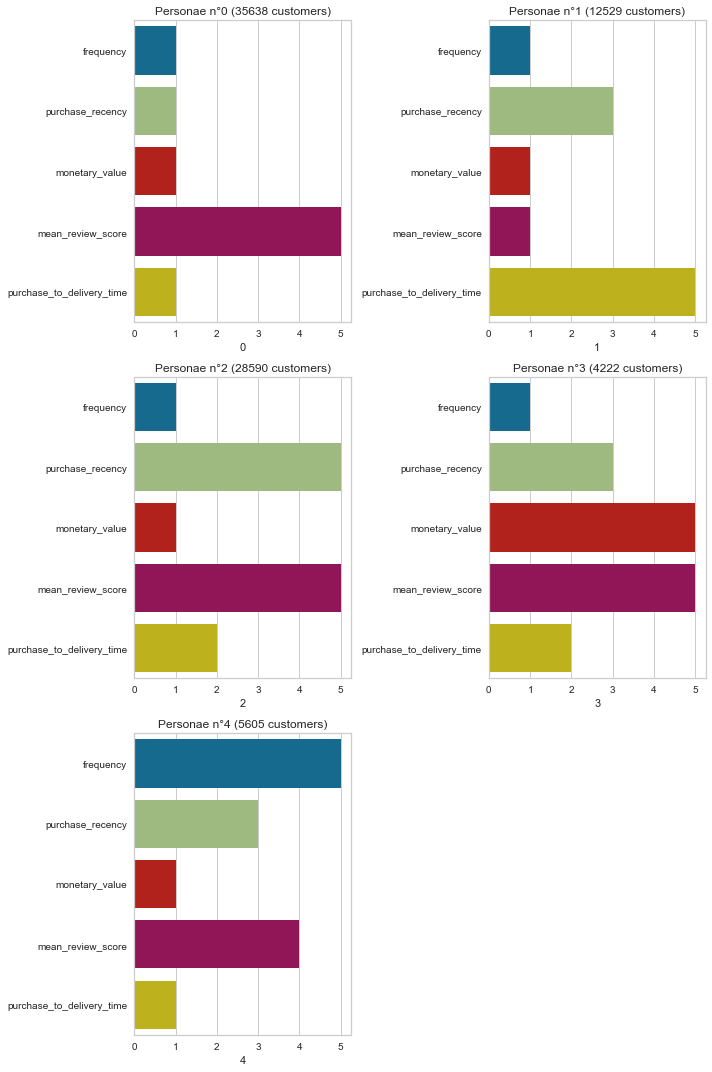

In [450]:
scores = make_score(clusters_data)
plot_personae(scores)

## stability

In [496]:
n_clust=6
aris = []
initial_centroids = X_std.sample(n_clust)
labels_orig = cluster.KMeans(n_clusters=n_clust, init=initial_centroids).fit(X_std).labels_

for i in range(10):
    initial_centroids = X_std.sample(n_clust)
    labels_new = cluster.KMeans(n_clusters=n_clust, init=initial_centroids).fit(X_std).labels_
    aris.append(adjusted_rand_score(labels_orig, labels_new))
print(aris)
print(np.mean(aris), np.std(aris))

/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMe

[0.9995534719374102, 0.8431959587363583, 0.9986213513995115, 0.9998432066957752, 0.7222463907490789, 0.7043873967599136, 0.9948046616587832, 0.7041641786091691, 0.723898387674557, 0.9995477237274939]
0.869026272794805 0.1346701407540341


# Slicing the dataset by time periods

We create a set of dataframes such that each dataframe correspond to a slice of the original dataframe over a given time period. 

In [639]:
# loading and cleaning the data
time_parser = dict(order_purchase_timestamp="datetime64[ns]")
X = (pd.read_csv('./data/raw_data.csv')
     .astype(time_parser)
    )
    
X = X[X.purchase_recency>=100]

# Creation of the time slices, and preprocessing
df_slices = get_time_slices(X, freq="months", periods=2, first_slice=True, first_freq="years", first_period=1)
df_slices = [data_preprocessing(sl) for sl in df_slices]
print("")
for i in range(len(df_slices)-1):
    nb_common = len(set(df_slices[i].index).intersection(set(df_slices[i+1].index)))
    print("Number of common customers in sets {} and {}: {}".format(i, i+1, nb_common))

Creation of the following slices:
DataFrame #	Start time		End time
----------------------------------------
DataFrame #0	2017-01-11 10:24:36	2018-01-11 10:22:52
DataFrame #1	2017-01-11 10:24:36	2018-03-11 10:15:39
DataFrame #2	2017-01-11 10:24:36	2018-05-11 10:19:57
DataFrame #3	2017-01-11 10:24:36	2018-07-11 10:13:01
DataFrame #4	2017-01-11 10:24:36	2018-08-29 15:00:37

Number of common customers in sets 0 and 1: 43452
Number of common customers in sets 1 and 2: 56472
Number of common customers in sets 2 and 3: 70160
Number of common customers in sets 3 and 4: 81330


In [630]:
df_slices[0].head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_comment_elapsed_time,mean_nb_installments,no,yes,accessories+_care_renovation-,health+_toys-,home+_toys-,fashion_clothing,food_beverages
customer_unique_id,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,158,86.22,25.0,3.0,1.0,8.0,1.0,0.0,-0.833349,-0.006625,-0.036364,-0.044399,-0.003506
0005e1862207bf6ccc02e4228effd9a0,1,152,150.12,4.0,4.0,6.0,3.0,1.0,0.0,0.779164,0.184684,-0.124363,3.870595,-0.078147
00115fc7123b5310cf6d3a3aa932699e,1,110,76.11,10.0,4.0,1.0,1.0,1.0,0.0,1.279855,1.615964,-0.953161,-0.408747,-0.019279
0011805441c0d1b68b48002f1d005526,1,203,297.14,18.0,3.0,1.0,10.0,1.0,0.0,-0.833349,-0.006625,-0.036364,-0.044399,-0.003506
0011857aff0e5871ce5eb429f21cdaf5,1,268,192.83,8.0,5.0,3.0,3.0,0.0,1.0,-0.833349,-0.006625,-0.036364,-0.044399,-0.003506


In [622]:
pd.Series(df_slices[0].columns.drop(["food_beverages", "mean_comment_elapsed_time", "yes"]))

0                         frequency
1                  purchase_recency
2                    monetary_value
3         purchase_to_delivery_time
4                 mean_review_score
5              mean_nb_installments
6                                no
7     accessories+_care_renovation-
8                     health+_toys-
9                       home+_toys-
10                 fashion_clothing
dtype: object

## Evaluating the stability of the clustering over time with ARI

In [640]:
aris = []
labels = []
base_df = df_slices[0]
base_indices = base_df.index

for df in df_slices:
    
    X = df.drop(columns=["food_beverages", "mean_comment_elapsed_time", "yes"],
               )
    X = X[X.index.isin(base_indices)]
    
    cat_cols = X.columns[7:]

    # Standard scaling of numerical features
    numeric_transformer = StandardScaler()  
    preproc = ColumnTransformer(transformers=[('num', StandardScaler(), X.columns.drop(cat_cols))],
                                remainder='passthrough'
                               )

    X_std = pd.DataFrame(data=preproc.fit_transform(X), columns=X.columns, index=X.index)

    clusters = cluster.KMeans(n_clusters=7).fit(X_std)
    labels.append(clusters.labels_)

    
print("Clustering stability evaluation")
print("DataFrame\tAdjusted Rand Index")
    
labels_orig = labels[0]
for i, l in enumerate(labels[1:]):
    ari = adjusted_rand_score(labels_orig, l)
    aris.append(ari)
    print("Period n°{:.0f}\t{:.3f}".format(i+1, ari))
    
print("Mean ARI: {:.3f}, standard deviation: {:.3f}".format(np.mean(aris), np.std(aris)))

Clustering stability evaluation
DataFrame	Adjusted Rand Index
Period n°1	0.980
Period n°2	0.825
Period n°3	0.818
Period n°4	0.816
Mean ARI: 0.860, standard deviation: 0.070
